In [1]:
import numpy as np
import matplotlib.pyplot as plt
from myImageLib import dirrec, bestcolor, bpass, wowcolor
from skimage import io, measure
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.signal import savgol_filter, medfilt
import os
from corrLib import corrS, corrI, divide_windows, distance_corr, corrIseq, readseq, match_hist
from scipy.signal import savgol_filter
from corrLib import boxsize_effect_spatial
import matplotlib as mpl
from numpy.polynomial.polynomial import polyvander
from scipy.optimize import curve_fit
from miscLib import label_slope
from corrLib import density_fluctuation
from scipy import signal
import pdb
%matplotlib nbagg

## Correlation vs. density

### Boxsize = 6.6 um

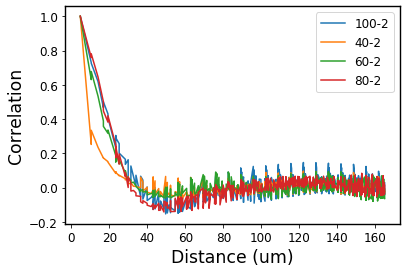

In [33]:
data = pd.read_csv(r'I:\Github\Python\Correlation\test_images\cl\result\cl_data_20.csv')
names = data.Name.drop_duplicates()
for name in names:
    dc = data.loc[data.Name==name]
    x = np.array(dc.R)
    y = np.array(dc.C)
    xx = x[(x<500)]
    yy = savgol_filter(y[(x<500)], 51, 3)
    yy = y[x<500]
    plt.plot(xx*0.33, yy, label=name)
plt.legend()
plt.xlabel('Distance (um)')
plt.ylabel('Correlation')
plt.savefig(r'I:\Github\Python\Correlation\test_images\cl\result\cl_plot_20.png', dpi=150)

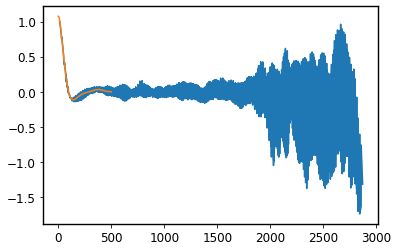

In [44]:
plt.plot(x, y)
fitting_range = 500
xsolve = np.array(range(0, fitting_range))
p = np.polyfit(x[xsolve], y[xsolve], 8)
yfit = np.dot(polyvander(xsolve, 8), np.flip(p).transpose())
plt.plot(xsolve, yfit)

In [12]:
def readdata(folder):
    dataDirs = dirrec(folder, '*.csv')
    nameList = []
    dirList = []
    for dataDir in dataDirs:
        path, file = os.path.split(dataDir)
        name, ext = os.path.splitext(file)
        nameList.append(name)
        dirList.append(dataDir)
    fileList = pd.DataFrame()
    fileList = fileList.assign(Name=nameList, Dir=dirList)
    fileList.Name = fileList.Name.astype('int32')
    fileList = fileList.sort_values(by=['Name'])
    return fileList

In [57]:
def corrlength(corrData, fitting_range=1000):
    xx = np.array(corrData.R)
    yy = np.array(corrData.C)
    x = xx[xx<fitting_range]
    y = yy[xx<fitting_range]
    p = np.polyfit(x, y, 8)
    xsolve = np.array(range(0, fitting_range))
    yfit = np.dot(polyvander(xsolve, 8), np.flip(p).transpose())
    try:
#         corrlen = xsolve[yfit>1/np.e].max()
        corrlen = xsolve[yfit>1/np.e].max()
    except:
        corrlen = 0
    return corrlen

In [100]:
# Kinetics
corrL = []
frame = []
folder = r'D:\Wei\transient\040\result'
l = readdata(folder)
count = 0
interval = 100
for num, i in l.iterrows():
    if num % interval != 0:
        continue
    data = pd.read_csv(i.Dir)
    corrlen = corrlength(data)
    frame.append(int(i.Name))
    corrL.append(corrlen)
    count += 1

Text(0, 0.5, 'Correlation length ($\\mu$m)')

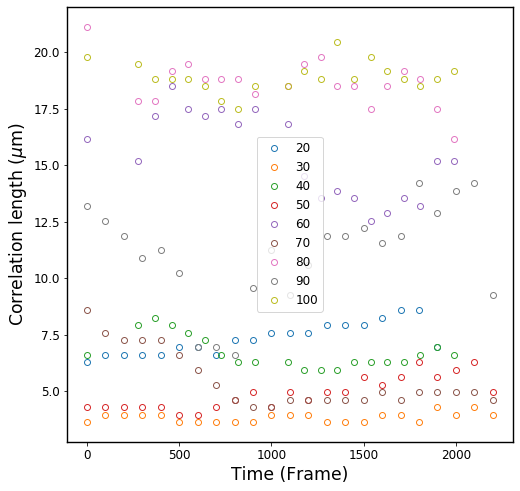

In [58]:
%matplotlib inline
plt.figure(figsize=(8,8))
folders = [r'D:\Wei\transient\cl_result\020',
          r'D:\Wei\transient\cl_result\030',
          r'D:\Wei\transient\cl_result\040',
          r'D:\Wei\transient\cl_result\050',
          r'D:\Wei\transient\cl_result\060',
          r'D:\Wei\transient\cl_result\070',
          r'D:\Wei\transient\cl_result\080',
          r'D:\Wei\transient\cl_result\090',
          r'D:\Wei\transient\cl_result\100']
names = ['20', '30', '40', '50', '60', '70', '80', '90', '100']
count1 = 0
rec = pd.DataFrame()
for name, folder in zip(names, folders):
    corrL = []
    frame = []
    l = readdata(folder)
    count = 0
    interval = 100
    for num, i in l.iterrows():
        if num % interval != 0:
            count += 1
            continue
        data = pd.read_csv(i.Dir)
        corrlen = corrlength(data, fitting_range=300)
        frame.append(int(i.Name))
        corrL.append(corrlen)
        subrec = pd.DataFrame().assign(frame=frame, corrL=corrL, concentration=name)
        count += 1
    rec = rec.append(subrec)
    plt.plot(frame, np.array(corrL)*0.33, label=name, ls='', marker='o',
            mfc=(0,0,0,0), mec=bestcolor(count1))
    count1 += 1
plt.legend()
plt.xlabel('Time (Frame)')
plt.ylabel('Correlation length ($\mu$m)')

In [49]:
rec.loc[rec.concentration==100]

,frame,corrL,concentration


In [127]:
def plot_cl(folders, labels, t_interval=100, fitting_range=400, mpp=0.33):
    plt.figure(figsize=(10,7))
    count1 = 0
    rec = pd.DataFrame()
    for name, folder in zip(labels, folders):
        corrL = []
        frame = []
        l = readdata(folder)
        count = 0
        interval = t_interval
        for num, i in l.iterrows():
            if num % interval != 0:
                count += 1
                continue
            data = pd.read_csv(i.Dir)
            corrlen = corrlength(data, fitting_range=fitting_range)
            frame.append(int(i.Name))
            corrL.append(corrlen)
            subrec = pd.DataFrame().assign(frame=frame, corrL=corrL, concentration=name)
            count += 1
        rec = rec.append(subrec)
        plt.plot(frame, np.array(corrL)*mpp, label=name, ls='', marker='o',
                mfc=(0,0,0,0), mec=bestcolor(count1))
        count1 += 1
    plt.legend()
    plt.xlabel('Time (Frame)')
    plt.ylabel('Correlation length ($\mu$m)')

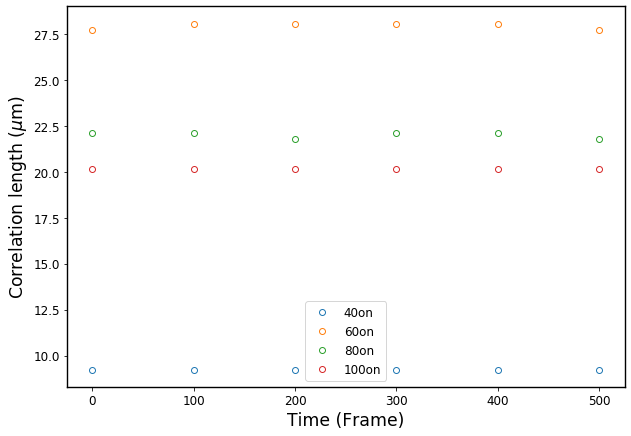

In [128]:
folders = [r'D:\Wei\overnight\cl_result\040on',
          r'D:\Wei\overnight\cl_result\060on',
          r'D:\Wei\overnight\cl_result\080on',
          r'D:\Wei\overnight\cl_result\100on']
labels = ['40on', '60on', '80on', '100on']
plot_cl(folders, labels)

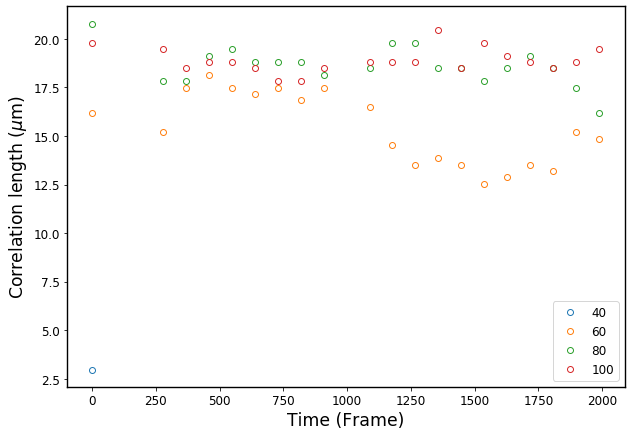

In [129]:
folders = [r'D:\Wei\transient\cl_result\40-5',
          r'D:\Wei\transient\cl_result\060',
          r'D:\Wei\transient\cl_result\080',
          r'D:\Wei\transient\cl_result\100']
labels = ['40', '60', '80', '100']
plot_cl(folders, labels)

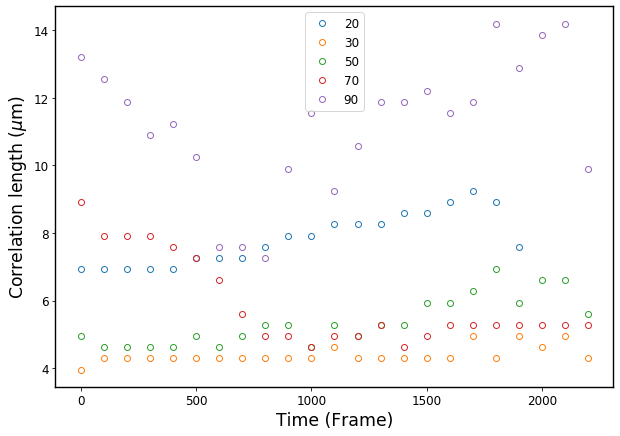

In [131]:
folders = [r'D:\Wei\transient\cl_result\020',
          r'D:\Wei\transient\cl_result\030',
          r'D:\Wei\transient\cl_result\050',
          r'D:\Wei\transient\cl_result\070',
          r'D:\Wei\transient\cl_result\090']
labels = ['20', '30', '50', '70', '90']
plot_cl(folders, labels)

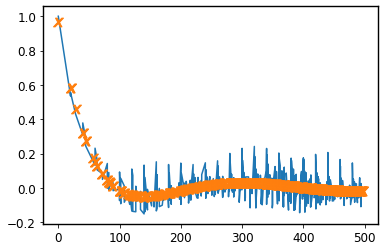

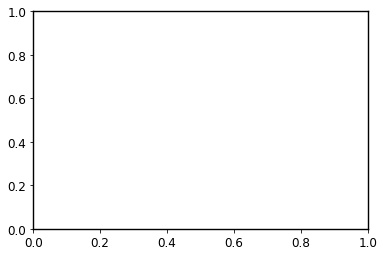

In [121]:
# check fittings one by one
%matplotlib inline
folder = r'D:\Wei\transient\cl_result\090'
l = readdata(folder)
for num, i in l.iterrows():
    if i.Name != 400:
        continue
    data = pd.read_csv(i.Dir)
    xx = np.array(data.R)
    yy = np.array(data.C)
    x = xx[xx<500]
    y = yy[xx<500]
    p = np.polyfit(x, y, 8)
    yfit = np.dot(polyvander(x, 8), np.flip(p).transpose())
    plt.plot(x, y)
    plt.plot(x, yfit, marker='$x$', ls='', markersize=10)    
    plt.pause(.5)
    plt.cla()

### Boxsize = 1.8 um

<IPython.core.display.Javascript object>


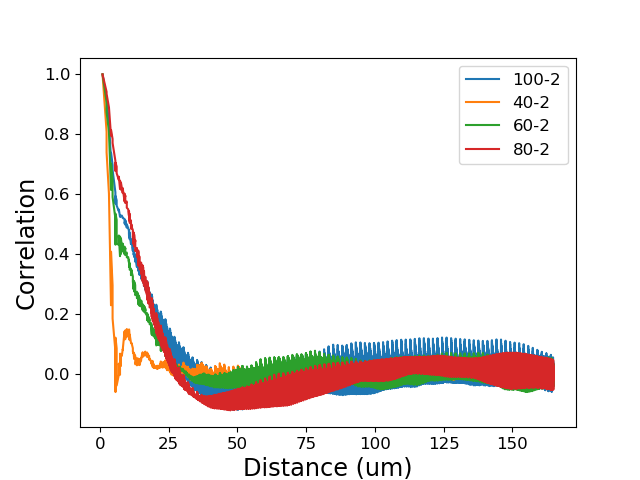

In [103]:
data = pd.read_csv(r'E:\Github\Python\Correlation\test_images\cl\result\cl_data_5.csv')
for name in data.Name.drop_duplicates():
    subdata = data.loc[data.Name==name]    
    x = np.array(subdata.R)
    y = np.array(subdata.C)
    xx = x[(x<500)]
    yy = savgol_filter(y[(x<500)], 1001, 3)
    yy = y[x<500]
    plt.plot(xx*0.33, yy, label=name)
plt.legend()
plt.xlabel('Distance (um)')
plt.ylabel('Correlation')
plt.savefig(r'E:\Github\Python\Correlation\test_images\cl\result\cl_plot_5.png', dpi=150)

## Box size effect on spatial intensity correlation

### boxsize effect on bandpassed image

<IPython.core.display.Javascript object>


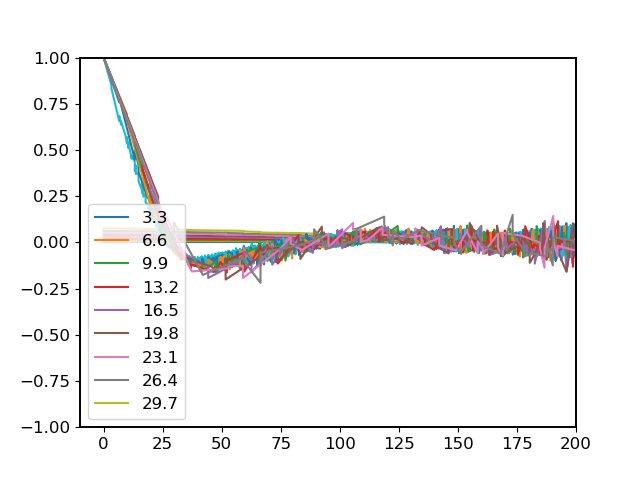

In [452]:
img = io.imread(r'I:\Github\Python\Correlation\test_images\boxsize_effect\80-2.tif')
bp = bpass(img, 5, 100)
boxsize = range(10, 100, 10)
mpp= 0.33
data = boxsize_effect_spatial(bp, boxsize, mpp)

<IPython.core.display.Javascript object>


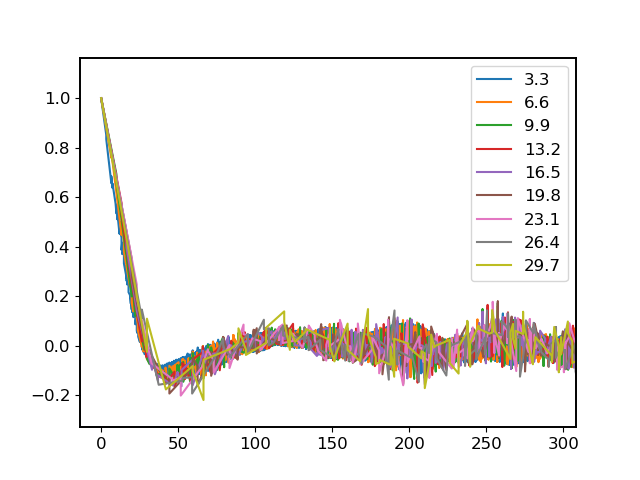

In [460]:
for kw in data:
    x = data[kw].R
    y = data[kw].C
    plt.plot(x, y, label=kw)
plt.axis([-10, 200, -1, 1])
plt.legend()

### bandpass effect on spatial correlation

In [7]:
# No bpass
nbdata = pd.read_csv(r'E:\Github\Python\Correlation\test_images\boxsize_effect\80-2_data.csv')
bdata = pd.read_csv(r'E:\Github\Python\Correlation\test_images\boxsize_effect\boxsize_effect_data.csv')
nbdata1 = nbdata.loc[nbdata.boxsize_um==3.3]
bdata1 = bdata.loc[bdata.boxsize==3.3]

<IPython.core.display.Javascript object>


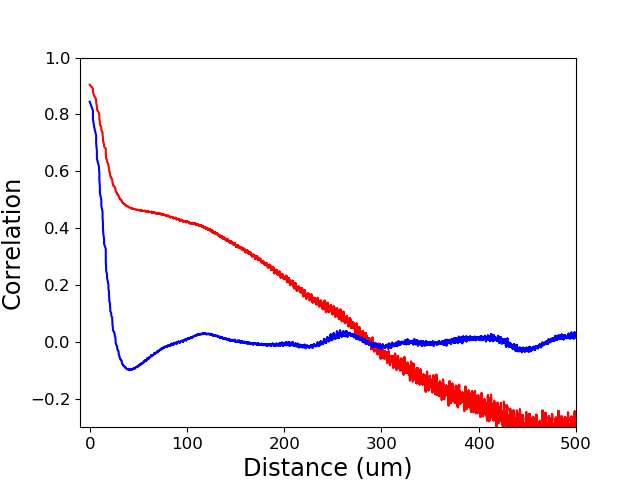

In [42]:
%matplotlib nbagg
plt.plot(nbdata1.R, savgol_filter(nbdata1.C, 101, 3), color='red')
plt.plot(bdata1.R, savgol_filter(bdata1.C, 101, 3), color='blue')
plt.axis([-10, 500, -0.3, 1])
plt.xlabel('Distance (um)')
plt.ylabel('Correlation')
plt.savefig(r'E:\Github\Python\Correlation\test_images\boxsize_effect\bpass_effect.png', dpi=150)

## Direct measurement of characteristic length scale

In [127]:
img = io.imread(r'I:\Github\Python\Correlation\test_images\boxsize_effect\80-2bp.tif')
rows = np.floor(np.linspace(0, img.shape[0]-1, 5))
rowI = img[[   0,  511, 1023, 1535, 2047], :]
    

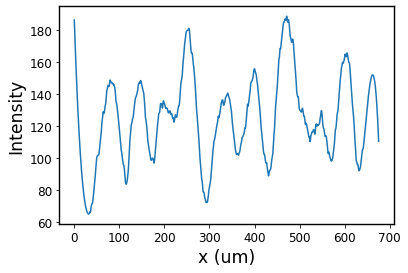

In [132]:
plt.plot(np.array(range(0, len(rowI[2])))*0.33, savgol_filter(rowI[1], 201, 3))
plt.xlabel('x (um)')
plt.ylabel('Intensity')
plt.savefig(r'I:\Google Drive\Research projects\DF\Figures\fig1-experiment\p2.svg', format='svg')

## Correlation length kinetics and average

In [ ]:
cl = pd.read_csv(r'I:/Data/Wei/transient/cl_result/03/222.csv')
plt.plot(cl.R*0.33, savgol_filter(cl.C, 51, 3))
plt.axis([-5, 500, -1, 1])

<IPython.core.display.Javascript object>


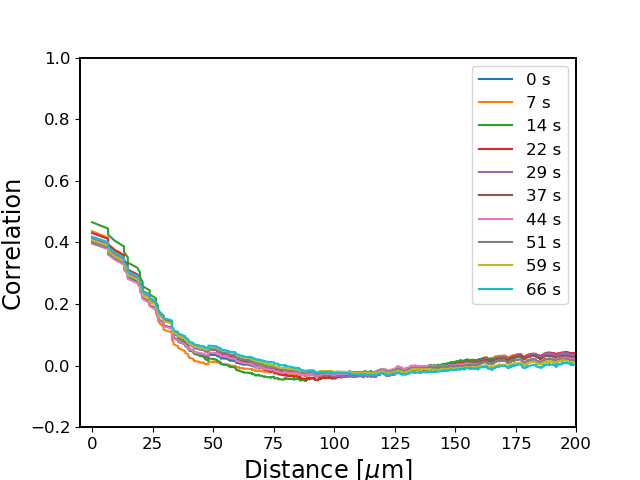

Text(0, 0.5, 'Correlation')

In [131]:
frames = np.floor(np.linspace(0, 1999, 10))
for frame in frames:
    cl = pd.read_csv(r'I:/Data/Wei/transient/cl_result/00/{0:d}.csv'.format(int(frame)))
    plt.plot(cl.R*0.33, savgol_filter(cl.C, 101, 3), label=str(int(frame/fps))+' s')
plt.legend()
plt.axis([-5, 200, -.2, 1]) 
plt.xlabel('Distance [$\mu$m]')
plt.ylabel('Correlation')

* length of cl data is 10404, so we filter the data with savgol_filter at 101 window length, to avoid error in locating local minima 

In [134]:
frames = np.floor(np.linspace(0, 1999, 200))
mpp = 0.33
clList = []
for frame in frames:
    cl = pd.read_csv(r'I:/Data/Wei/transient/cl_result/00/{0:d}.csv'.format(int(frame)))
    cl.R = cl.R * mpp
    cl.C = savgol_filter(cl.C, 101, 3)
    corrlen = cl.at[cl.C.loc[(cl.R>25)&(cl.R<70)].idxmin(), 'R']
    clList.append(corrlen)

<IPython.core.display.Javascript object>


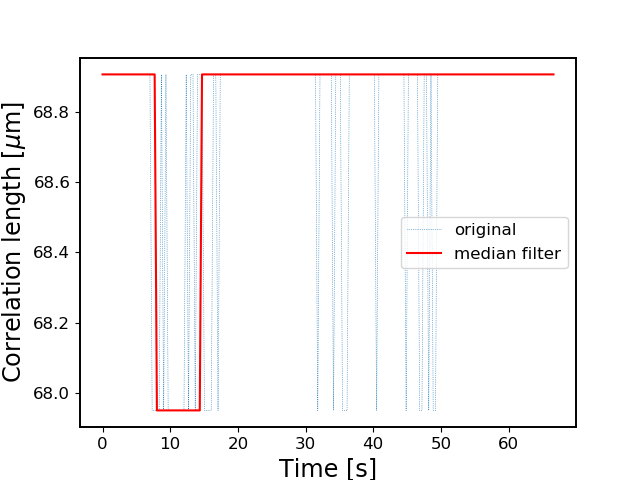

Text(0, 0.5, 'Correlation length [$\\mu$m]')

In [135]:
fps = 30
clList = np.array(clList)
plt.plot(frames/fps, clList, label='original', lw=0.5, ls=':')
plt.plot(frames/fps, medfilt(clList, kernel_size=21), label='median filter', color='red')
plt.legend()
plt.xlabel('Time [s]')

plt.ylabel('Correlation length [$\mu$m]')

## Giant number fluctuation analysis

In [15]:
img = io.imread(r'I:\Github\Python\Correlation\test_images\boxsize_effect\0001.tif')
boxsize = np.unique(np.floor(np.logspace(0, 2.5, 100)))
NList = []
dNList = []
for bs in boxsize:
    X, Y, I = divide_windows(img, windowsize=[bs, bs], step=bs)
    N = (255-I.mean())*bs*bs
    dN = I.std()*bs*bs
    NList.append(N)
    dNList.append(dN)

In [1]:
n = np.array(NList)
d = np.array(dNList)
plt.plot(n, d/n**.5)
plt.xscale('log')
plt.yscale('log')

NameError: name 'np' is not defined

### Analyze density fluctuation of an 8-bit grayscale image

In [308]:
folder = r'I:\Data\Wei\transient\02\i50bp'
l = readseq(folder)
data = pd.DataFrame()
for num, i in l.iterrows():
    print('Processing frame' + i.Name)
    img = io.imread(i.Dir)
    df = density_fluctuation(img)

Processing frame0000
Processing frame0001
Processing frame0002
Processing frame0003
Processing frame0004
Processing frame0005
Processing frame0006
Processing frame0007
Processing frame0008
Processing frame0009
Processing frame0010
Processing frame0011
Processing frame0012
Processing frame0013
Processing frame0014
Processing frame0015
Processing frame0016
Processing frame0017
Processing frame0018
Processing frame0019
Processing frame0020
Processing frame0021
Processing frame0022
Processing frame0023
Processing frame0024
Processing frame0025
Processing frame0026
Processing frame0027
Processing frame0028
Processing frame0029
Processing frame0030
Processing frame0031
Processing frame0032
Processing frame0033
Processing frame0034
Processing frame0035
Processing frame0036
Processing frame0037
Processing frame0038
Processing frame0039


<IPython.core.display.Javascript object>


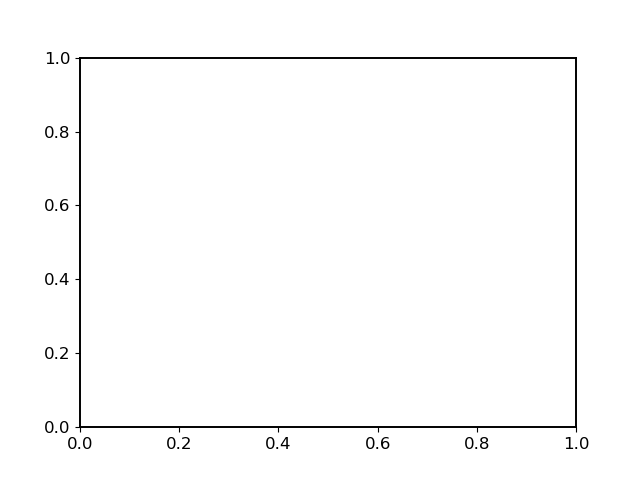

In [389]:
folder = r'I:\Data\Wei\transient\02\i50bp\GNFplot'
data = pd.read_csv(r'I:\Data\Wei\transient\02\i50bp\GNFdata.csv')
for frame in data.frame.drop_duplicates():
    subdata = data.loc[data.frame==frame]
    plt.plot(subdata.n, subdata.d)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('N')
    plt.ylabel('dN')
    plt.savefig(os.path.join(folder, str(frame)+'.png'), dpi=150)
    plt.cla()

In [290]:
img = io.imread(r'I:\Github\Python\Correlation\test_images\GNF\500bp.tif')
n, d = density_fluctuation(img)

<IPython.core.display.Javascript object>


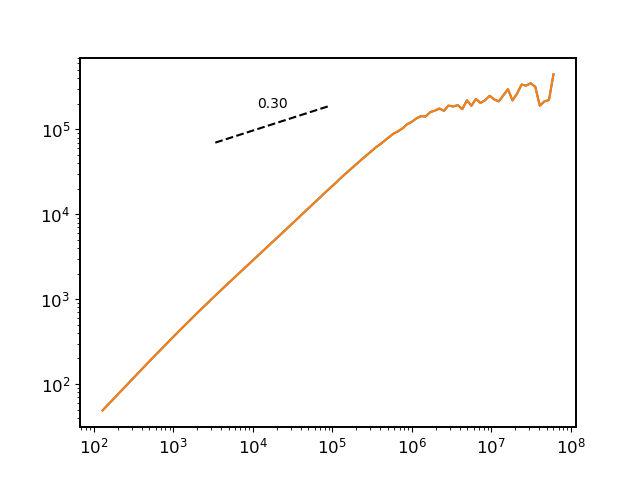

In [292]:
plt.plot(n, d)
plt.xscale('log')
plt.yscale('log')

In [393]:
xf, yf, xt, yt, slope = label_slope(n, d, location='n')

### Bandpass effect on density fluctuation

In [106]:
nbimg = io.imread(r'I:\Github\Python\Correlation\test_images\boxsize_effect\80-2.tif')
bimg = io.imread(r'I:\Github\Python\Correlation\test_images\boxsize_effect\80-2bp.tif')
n, d = density_fluctuation(nbimg)
n1, d1 = density_fluctuation(bimg)
plt.plot(n, d, marker='o', ls='', mfc=(0,0,0,0), mec='red')
plt.plot(n1, d1, marker='s', ls='', mfc=(0,0,0,0), mec='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$N$')
plt.ylabel('$\Delta N$ ')
plt.savefig(r'I:\Github\Python\Correlation\test_images\boxsize_effect\bpass_effect_DF.png', dpi=150)

TypeError: density_fluctuation() missing 2 required positional arguments: 'conc' and 'mpp'

In [204]:
def density_fluctuation(img8):
    row, col = img8.shape
    l = min(row, col)
    size_min = 20    
    boxsize = np.unique(np.floor(np.logspace(np.log10(size_min), np.log10((l-size_min-1)/2), 100)))
    # Gradually increase box size and calculate dN=std(I) and N=mean(I)    
    # choose maximal box size to be 1/3 of the shorter edge of the image 
    # to guarantee we have multiple boxes for each calculation, so that
    # the statistical quantities are meaningful.
    bp = bpass(img8, 3, 100)
    img8_mh = match_hist(bp, img8)
    NList = []
    dNList = []
    for bs in boxsize:
        X, Y, I = divide_windows(img8_mh, windowsize=[bs, bs], step=5*size_min)
        N = bs*bs
        dN = np.log10(I).std()*bs*bs
        NList.append(N)
        dNList.append(dN)
    df_data = pd.DataFrame().assign(n=NList, d=dNList)
    return df_data

In [134]:
%%time
bimg = io.imread(r'I:\Github\Python\Correlation\test_images\boxsize_effect\80-2bp.tif')
df = density_fluctuation(bimg)

S:\Anaconda\3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
S:\Anaconda\3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Wall time: 1min 10s


In [205]:
%%time 
# min_size=20, step=min_size, t=1min 35s
# min_size=20, step=boxsize, t=3.1s
# min_size=20, step=5*min_size, t=5.14 s
# Thus, step=5*min_size is a good choice
bimg = io.imread(r'I:\Github\Python\Correlation\test_images\boxsize_effect\80-2bp.tif')
df = density_fluctuation(bimg)

Wall time: 5.14 s


Text(997.3624151794904, 193.37310720667423, '0.78')

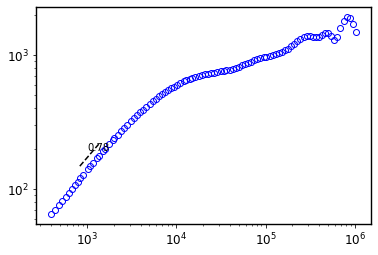

In [198]:
# min_size=20, step=min_size, t=1min 35s
x = df.n.loc[df.n<3e3]
y = df.d.loc[df.n<3e3]
plt.plot(df.n, df.d, ls='', marker='o', mfc=(0,0,0,0), mec='blue')
plt.xscale('log')
plt.yscale('log')
xf, yf, xt, yt, slope = label_slope(x, y, location='n')
plt.plot(xf, yf, ls='--', color='black')
plt.text(xt, yt, '{:.2f}'.format(slope))

Text(997.3624151794904, 192.43177025176882, '0.77')

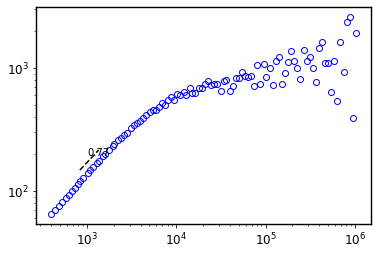

In [202]:
# min_size=20, step=boxsize, t=3.1s
x = df.n.loc[df.n<3e3]
y = df.d.loc[df.n<3e3]
plt.plot(df.n, df.d, ls='', marker='o', mfc=(0,0,0,0), mec='blue')
plt.xscale('log')
plt.yscale('log')
xf, yf, xt, yt, slope = label_slope(x, y, location='n')
plt.plot(xf, yf, ls='--', color='black')
plt.text(xt, yt, '{:.2f}'.format(slope))

Text(997.3624151794904, 184.15099041100947, '0.83')

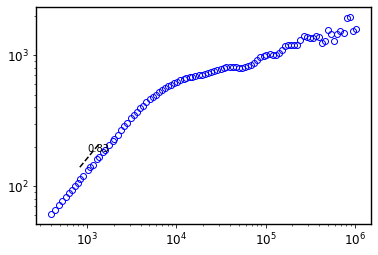

In [206]:
# min_size=20, step=5*min_size, t=5.14 s
x = df.n.loc[df.n<3e3]
y = df.d.loc[df.n<3e3]
plt.plot(df.n, df.d, ls='', marker='o', mfc=(0,0,0,0), mec='blue')
plt.xscale('log')
plt.yscale('log')
xf, yf, xt, yt, slope = label_slope(x, y, location='n')
plt.plot(xf, yf, ls='--', color='black')
plt.text(xt, yt, '{:.2f}'.format(slope))

In [187]:
l = 2000
size_min = 20
boxsize = np.unique(np.floor(np.logspace(np.log10(size_min), np.log10((l-size_min-1)/2), 100)))

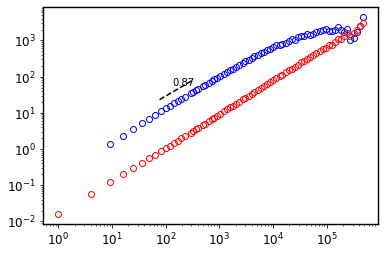

In [6]:
img = io.imread(r'D:\Wei\transient\060\  300.tif')
# df = density_fluctuation(img)
df = df.dropna()
x = df.n.loc[df.n<3e3]
y = df.d.loc[df.n<3e3]
plt.plot(df.n, df.d, ls='', marker='o', mfc=(0,0,0,0), mec='blue')
plt.xscale('log')
plt.yscale('log')
xf, yf, xt, yt, slope = label_slope(x, y, location='n')
plt.plot(xf, yf, ls='--', color='black')
plt.text(xt, yt, '{:.2f}'.format(slope))
odf = pd.read_csv(r'D:\Wei\transient\df_result\060\  300.csv')
plt.plot(odf.n, odf.d, ls='', marker='o', mfc=(0,0,0,0), mec='red')

In [5]:
y

0            NaN
1            NaN
2       1.333132
3       2.340289
4       3.610106
5       5.127438
6       6.890857
7       8.842685
8      11.028426
9      13.373594
10     15.922572
11     18.633401
12     21.498966
13     24.574033
14     27.677830
15     34.492811
16     37.955768
17     41.757463
18     45.939623
19     54.223693
20     58.621592
21     67.386236
22     77.242048
23     83.278619
24     93.368619
25    103.930497
26    121.733156
27    134.555693
28    154.312759
29    166.901432
30    187.145126
31    209.124245
32    239.439864
Name: d, dtype: float64

### Density fluctuation vs. density

In [68]:
# stationary
folder = r'E:\Github\Python\Correlation\test_images\GNF\stat'
l = readseq(folder)
data_stat = pd.DataFrame()
for num, i in l.iterrows():
    img = io.imread(i.Dir)
    img = bpass(img, 3, 100)
    n, d = density_fluctuation(img)
    data_t = pd.DataFrame().assign(n=n, d=d, Name=i.Name)
    data_stat = data_stat.append(data_t)
data_stat.to_csv(os.path.join(folder, 'data_bp.csv'))

In [73]:
# motion
folder = r'E:\Github\Python\Correlation\test_images\GNF\motion'
l = readseq(folder)
data_stat = pd.DataFrame()
for num, i in l.iterrows():
    img = io.imread(i.Dir)
    img = bpass(img, 3, 100)
    n, d = density_fluctuation(img)
    data_t = pd.DataFrame().assign(n=n, d=d, Name=i.Name)
    data_stat = data_stat.append(data_t)
data_stat.to_csv(os.path.join(folder, 'data_bp.csv'))

#### Original image density fluctuation

In [80]:
data_stat = pd.read_csv(r'E:\Github\Python\Correlation\test_images\GNF\stat\data.csv')
data_mot = pd.read_csv(r'E:\Github\Python\Correlation\test_images\GNF\motion\data.csv')

<IPython.core.display.Javascript object>


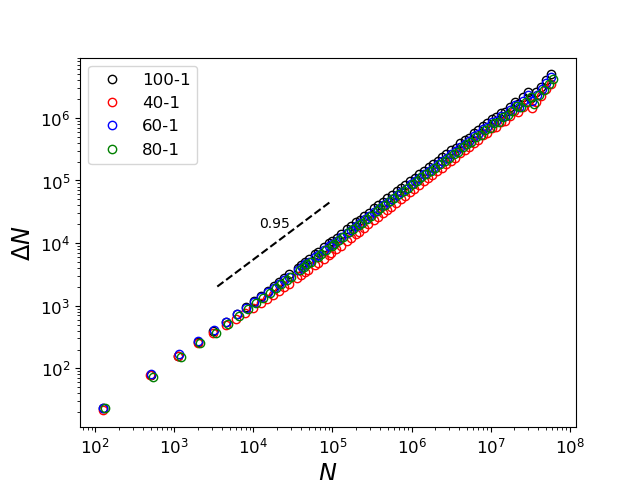

In [85]:
colors = ['black', 'red', 'blue', 'green']
for num, name in enumerate(data_stat.Name.drop_duplicates()):
    subdata = data_stat.loc[data_stat.Name==name]
    plt.plot(subdata.n, subdata.d, label=name, ls='', marker='o', mfc=(0,0,0,0), mec=colors[num])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$N$')
plt.ylabel('$\Delta N$ ')
plt.legend()
xf, yf, xt, yt, slope = label_slope(subdata.n, subdata.d, location='n')
plt.plot(xf, yf, ls='--', color='black')
plt.text(xt, yt, '{:.2f}'.format(slope))
plt.savefig(r'E:\Github\Python\Correlation\test_images\GNF\stat\DF_plot_stat.png', dpi=150)

<IPython.core.display.Javascript object>


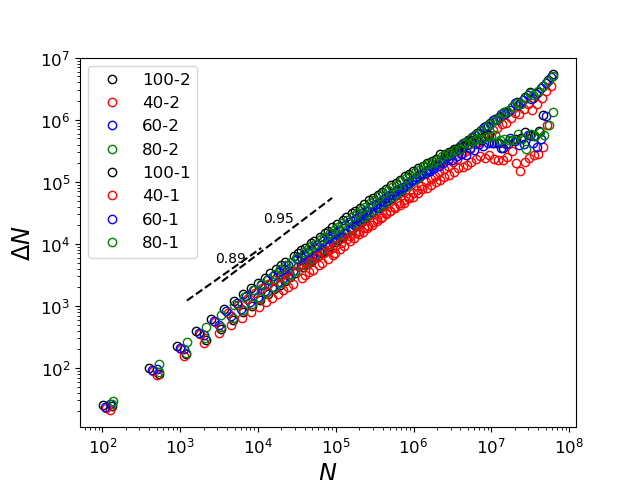

In [86]:
for num, name in enumerate(data_mot.Name.drop_duplicates()):
    subdata = data_mot.loc[data_mot.Name==name]
    plt.plot(subdata.n, subdata.d, label=name, ls='', marker='o', mfc=(0,0,0,0), mec=colors[num])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$N$')
plt.ylabel('$\Delta N$ ')
plt.legend()
xf, yf, xt, yt, slope = label_slope(subdata.n, subdata.d, location='n')
plt.plot(xf, yf, ls='--', color='black')
plt.text(xt, yt, '{:.2f}'.format(slope))
plt.savefig(r'E:\Github\Python\Correlation\test_images\GNF\stat\DF_plot_mot.png', dpi=150)

#### Bpassed images density fluctuation

In [74]:
data_stat_bp = pd.read_csv(r'E:\Github\Python\Correlation\test_images\GNF\stat\data_bp.csv')
data_mot_bp = pd.read_csv(r'E:\Github\Python\Correlation\test_images\GNF\motion\data_bp.csv')

<IPython.core.display.Javascript object>


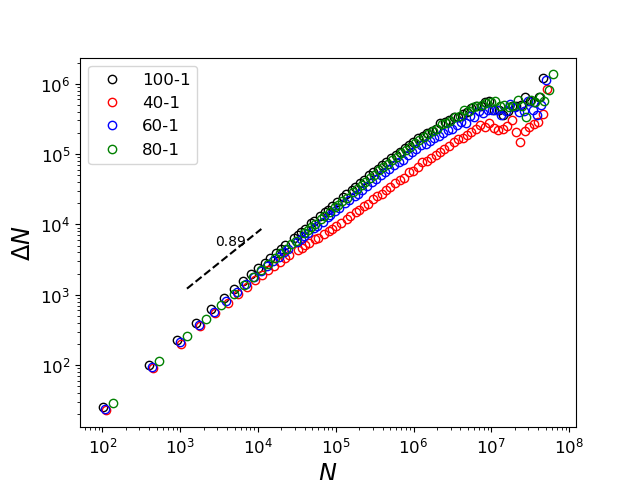

In [88]:
colors = ['black', 'red', 'blue', 'green']
for num, name in enumerate(data_stat_bp.Name.drop_duplicates()):
    subdata = data_stat_bp.loc[data_stat_bp.Name==name]
    plt.plot(subdata.n, subdata.d, label=name, ls='', marker='o', mfc=(0,0,0,0), mec=colors[num])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$N$')
plt.ylabel('$\Delta N$ ')
plt.legend()
xf, yf, xt, yt, slope = label_slope(subdata.n.loc[subdata.n<1e6], subdata.d.loc[subdata.n<1e6], location='n')
plt.plot(xf, yf, ls='--', color='black')
plt.text(xt, yt, '{:.2f}'.format(slope))
plt.savefig(r'E:\Github\Python\Correlation\test_images\GNF\stat\DF_plot_stat_bp.png', dpi=150)

<IPython.core.display.Javascript object>


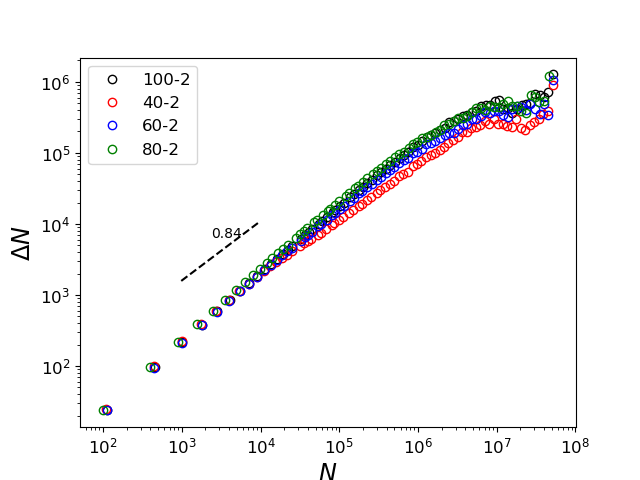

In [89]:
for num, name in enumerate(data_mot_bp.Name.drop_duplicates()):
    subdata = data_mot_bp.loc[data_mot_bp.Name==name]
    plt.plot(subdata.n, subdata.d, label=name, ls='', marker='o', mfc=(0,0,0,0), mec=colors[num])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$N$')
plt.ylabel('$\Delta N$ ')
plt.legend()
xf, yf, xt, yt, slope = label_slope(subdata.n.loc[subdata.n<1e6], subdata.d.loc[subdata.n<1e6], location='n')
plt.plot(xf, yf, ls='--', color='black')
plt.text(xt, yt, '{:.2f}'.format(slope))
plt.savefig(r'E:\Github\Python\Correlation\test_images\GNF\motion\DF_plot_mot_bp.png', dpi=150)

* Make a linear map from bp to bpt to match the intensity distribution of img

In [3]:
def match_hist(im1, im2):
    # match the histogram of im1 to that of im2
    return (abs(((im1 - im1.mean()) / im1.std() * im2.std() + im2.mean()))+1).astype('uint8')

In [12]:
# Show convert to number first and average intensity first give same result
l = readseq(r'I:\Github\Python\Correlation\test_images\GNF\motion')
diffL = []
for num, i in l.iterrows():
    img = io.imread(i.Dir)
    bp = bpass(img, 3, 100)
    bp_mh = match_hist(bp, img)[0:1,  0:1]
    a = np.log10(bp_mh.mean())
    b = np.log10(bp_mh).mean()
    diff = (a-b)/(a+b)*2
    diffL.append(diff)
    

<IPython.core.display.Javascript object>


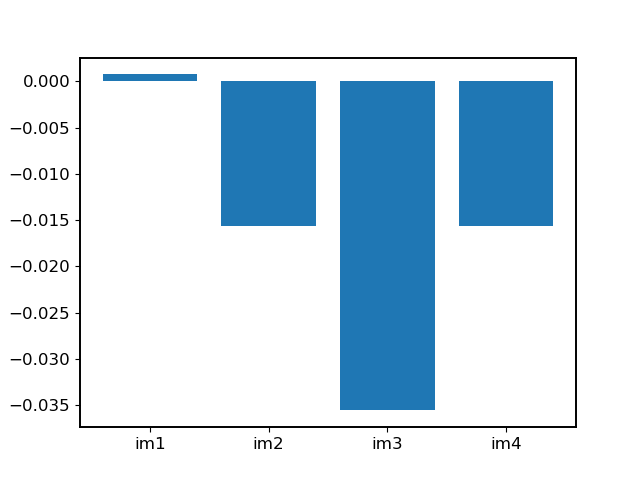

Text(0, 0.5, 'Difference (%)')

In [13]:
plt.bar(['im1', 'im2', 'im3', 'im4'], height=np.array(diffL)*100)
plt.ylabel('Difference (%)')

In [4]:
l = readseq(r'I:\Github\Python\Correlation\test_images\GNF\motion')
df = pd.DataFrame()
for num, i in l.iterrows():
    img = io.imread(i.Dir)
    bp = bpass(img, 3, 100)
    bp_mh = match_hist(bp, img)
    df_data = density_fluctuation(bp_mh).assign(Name=i.Name)
    df = df.append(df_data)

<IPython.core.display.Javascript object>


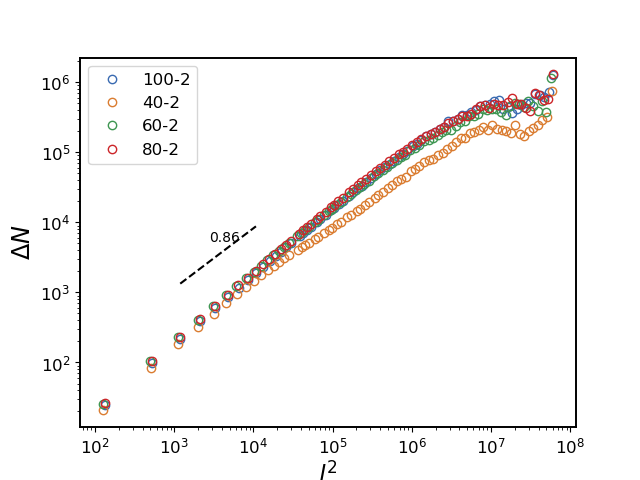

Text(0, 0.5, '$\\Delta N$')

In [9]:
%matplotlib nbagg
count = 0
for name in df.Name.drop_duplicates():
    subdata = df.loc[df.Name==name]
    n = subdata.n
    d = subdata.d    
    plt.plot(n, d, marker='o', ls='', mfc=(0,0,0,0), mec=bestcolor(count), label=name)
    count += 1
plt.legend()
plt.xscale('log')
plt.yscale('log')
xf, yf, xt, yt, slope = label_slope(n[n<1e6], d[n<1e6], location='n')
plt.plot(xf, yf, ls='--', color='black')
plt.text(xt, yt, '{:.2f}'.format(slope))
plt.xlabel('$l^2$')
plt.ylabel('$\Delta N$')

<IPython.core.display.Javascript object>


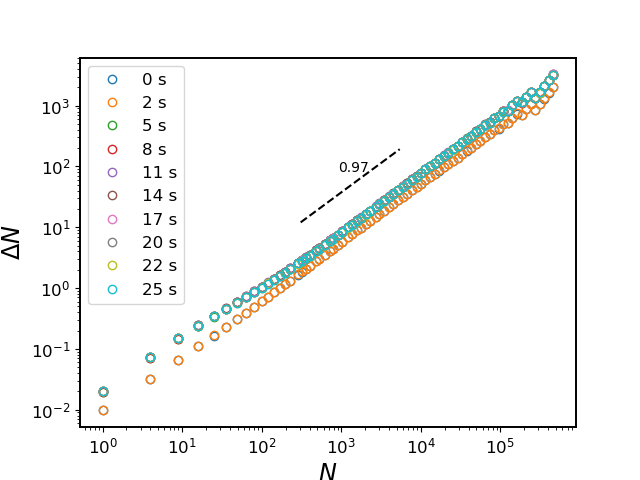

Text(0, 0.5, '$\\Delta N$')

In [39]:
%matplotlib nbagg
fps = 30
frames = np.floor(np.linspace(0, 776, 10))
count = 0
for frame in frames:
    df = pd.read_csv(r'I:\Data\Wei\transient\df_result\03\{:5d}.csv'.format(int(frame)))
    plt.plot(df.n, df.d, label=str(int(frame/fps))+' s', marker='o', mfc=(0,0,0,0), mec=bestcolor(count), ls='')
    count += 1
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$N$')
plt.ylabel('$\Delta N$')

* Fitting the power

In [40]:
xf, yf, xt, yt, slope = label_slope(df.n.loc[df.n<1e5], df.d.loc[df.n<1e5], location='ne')

In [41]:
plt.plot(xf, yf, ls='--', color='black')
plt.text(xt, yt, '{:.2f}'.format(slope))
plt.xscale('log')
plt.yscale('log')

* Slope of every curve

<IPython.core.display.Javascript object>


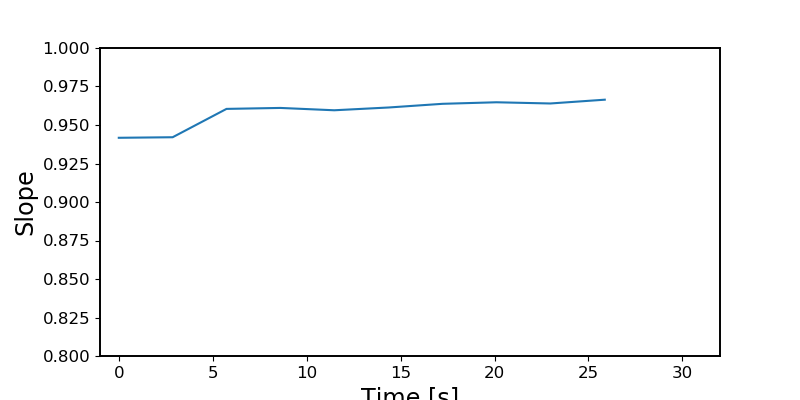

Text(0, 0.5, 'Slope')

In [43]:
slopes = []
plt.figure(figsize=[8, 4])
for frame in frames:
    df = pd.read_csv(r'I:\Data\Wei\transient\df_result\03\{:5d}.csv'.format(int(frame)))
    xf, yf, xt, yt, slope = label_slope(df.n.loc[df.n<1e5], df.d.loc[df.n<1e5], location='ne')
    slopes.append(slope)
plt.plot(frames/fps, slopes)
plt.axis([-1, 32, 0.8, 1])
plt.xlabel('Time [s]')
plt.ylabel('Slope')

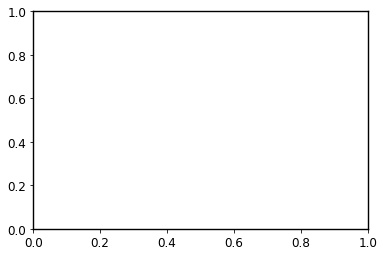

In [20]:
# Plot density fluctuation result
# 1. Plot for all .csv's, fit slope for x < 1e3
csvdirs = dirrec(r'D:\Wei\transient\df_result', '*.csv')
for d in csvdirs:
    df = pd.read_csv(d)
    x = df.n.loc[df.n<3e3]
    y = df.d.loc[df.n<3e3]
    plt.plot(df.n, df.d, ls='', marker='o', mfc=(0,0,0,0), mec='blue')
    plt.xscale('log')
    plt.yscale('log')
    xf, yf, xt, yt, slope = label_slope(x, y, location='n')
    plt.plot(xf, yf, ls='--', color='black')
    plt.text(xt, yt, '{:.2f}'.format(slope), fontsize=15)
    plt.title(d.replace('D:\\Wei\\transient\\df_result\\', '').replace('.csv', ''))
    plt.xlabel('$N$')
    plt.ylabel('$\Delta N$')
    plt.savefig(d.replace('csv', 'png'))
    plt.cla()

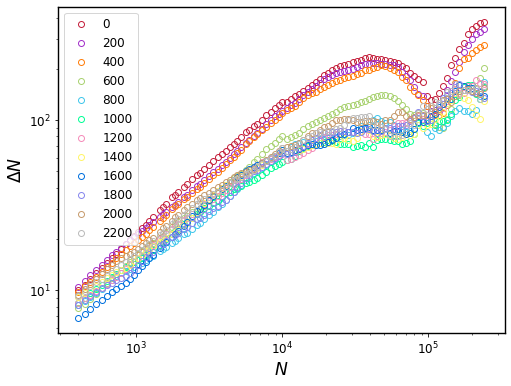

In [23]:
#plot different time on same axis
plt.figure(figsize=(8, 6))
csvdirs = dirrec(r'D:\Wei\transient\df_result_500\070', '*.csv')
count = 0
for d in csvdirs:
    if count % 4 != 0:
        count += 1
        continue
    df = pd.read_csv(d)
    plt.plot(df.n, df.d, label=str(count*50),ls='', \
             mfc=(0,0,0,0), mec=wowcolor(int(count/4)), marker='o')
    count += 1
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$N$')
plt.ylabel('$\Delta N$')
plt.legend()

Plot $\Delta N/N^{0.5}$ vs. $l^2/L^2$

* Average NF data at 40, 60, 80 and 100 n$_0$, in range 250-500 frames.

In [34]:
folder = r'D:\Wei\transient\df_result_500\040'
l = readdata(folder)
count = 0
for num, i in l.iterrows():
    if i.Name < 250 or i.Name > 500:
        continue
    
    tmp = pd.read_csv(i.Dir)
    if count == 0:
        data = tmp
    else:
        data += tmp
    count += 1
avg_data = data / count

In [10]:
def average_NF(folder, avrange=[250, 500]):
    l = readdata(folder)
    count = 0
    for num, i in l.iterrows():
        if i.Name < avrange[0] or i.Name > avrange[1]:
            continue
        tmp = pd.read_csv(i.Dir)
        if count == 0:
            data = tmp
        else:
            data += tmp
        count += 1
    return data / count

In [16]:
folders = [r'D:\Wei\transient\df_result\030',
           r'D:\Wei\transient\df_result\040',
           r'D:\Wei\transient\df_result\050',
           r'D:\Wei\transient\df_result\060',
           r'D:\Wei\transient\df_result\070',
           r'D:\Wei\transient\df_result\080',
           r'D:\Wei\transient\df_result\090',
           r'D:\Wei\transient\df_result\100']
data = pd.DataFrame()
for f in folders:
    a = average_NF(f, avrange=[1000, 1300])
    name = int(os.path.split(f)[1])
    a = a.assign(Name=name)
    data = data.append(a)


Text(0, 0.5, '$\\Delta N/N^{0.5}$')

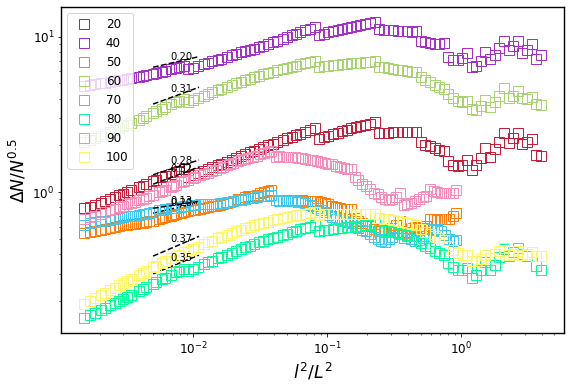

In [86]:
count = 0
plt.figure(figsize=(9, 6))
# ## 20 n0
# img = io.imread(r'D:\Wei\transient\20_crop\0400.tif')
# df = density_fluctuation(img)
# xx = df.n/510**2
# yy = df.d/df.n**.5
# plt.plot(xx, yy, label=str(20), ls='', marker='s',
#         mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
# x = xx.loc[df.n<1e4]
# y = yy.loc[df.n<1e4] 
# xf, yf, xt, yt, slope = label_slope(x, y, location='n')
# plt.plot(xf, yf, ls='--', color='black')
# plt.text(xt, yt, '{:.2f}'.format(slope))
# count += 1
# ####
# ## 30 n0
# img = io.imread(r'D:\Wei\transient\030\00400.tif')
# df = density_fluctuation(img)
# xx = df.n/510**2
# yy = df.d/df.n**.5
# plt.plot(xx, yy, label=str(30), ls='', marker='s',
#         mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
# x = xx.loc[df.n<1e4]
# y = yy.loc[df.n<1e4] 
# xf, yf, xt, yt, slope = label_slope(x, y, location='n')
# plt.plot(xf, yf, ls='--', color='black')
# plt.text(xt, yt, '{:.2f}'.format(slope))
# count += 1
# ####
# ## 50 n0
# img = io.imread(r'D:\Wei\transient\050\00400.tif')
# df = density_fluctuation(img)
# xx = df.n/510**2
# yy = df.d/df.n**.5
# plt.plot(xx, yy, label=str(50), ls='', marker='s',
#         mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
# x = xx.loc[df.n<1e4]
# y = yy.loc[df.n<1e4] 
# xf, yf, xt, yt, slope = label_slope(x, y, location='n')
# plt.plot(xf, yf, ls='--', color='black')
# plt.text(xt, yt, '{:.2f}'.format(slope))
# count += 1
# ####


for name in data.Name.drop_duplicates():
    subdata = data.loc[data.Name==name]
    
    # to plot, xx yy
    xx = subdata.n/510**2
    yy = subdata.d/subdata.n**.5
       
    plt.plot(xx, yy, label=str(name), ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
    # to fit
    x = xx.loc[subdata.n<1e4]
    y = yy.loc[subdata.n<1e4] 
    xf, yf, xt, yt, slope = label_slope(x, y, location='n')
    plt.plot(xf, yf, ls='--', color='black')
    plt.text(xt, yt, '{:.2f}'.format(slope))
    count += 1


plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/L^2$')
plt.ylabel('$\Delta N/N^{0.5}$')

Text(0, 0.5, '$\\Delta N/N^{0.5}$')

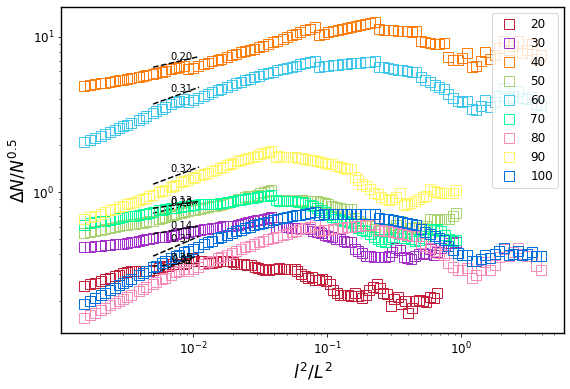

In [17]:
count = 0
plt.figure(figsize=(9, 6))
## 20 n0
img = io.imread(r'D:\Wei\transient\20_crop\0400.tif')
df = density_fluctuation(img)
xx = df.n/510**2
yy = df.d/df.n**.5
plt.plot(xx, yy, label=str(20), ls='', marker='s',
        mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
x = xx.loc[df.n<1e4]
y = yy.loc[df.n<1e4] 
xf, yf, xt, yt, slope = label_slope(x, y, location='n')
plt.plot(xf, yf, ls='--', color='black')
plt.text(xt, yt, '{:.2f}'.format(slope))
count += 1
####
# ## 30 n0
# img = io.imread(r'D:\Wei\transient\030\00400.tif')
# df = density_fluctuation(img)
# xx = df.n/510**2
# yy = df.d/df.n**.5
# plt.plot(xx, yy, label=str(30), ls='', marker='s',
#         mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
# x = xx.loc[df.n<1e4]
# y = yy.loc[df.n<1e4] 
# xf, yf, xt, yt, slope = label_slope(x, y, location='n')
# plt.plot(xf, yf, ls='--', color='black')
# plt.text(xt, yt, '{:.2f}'.format(slope))
# count += 1
# ####
# ## 50 n0
# img = io.imread(r'D:\Wei\transient\050\00400.tif')
# df = density_fluctuation(img)
# xx = df.n/510**2
# yy = df.d/df.n**.5
# plt.plot(xx, yy, label=str(50), ls='', marker='s',
#         mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
# x = xx.loc[df.n<1e4]
# y = yy.loc[df.n<1e4] 
# xf, yf, xt, yt, slope = label_slope(x, y, location='n')
# plt.plot(xf, yf, ls='--', color='black')
# plt.text(xt, yt, '{:.2f}'.format(slope))
# count += 1
# ####


for name in data.Name.drop_duplicates():
    subdata = data.loc[data.Name==name]
    
    # to plot, xx yy
    xx = subdata.n/510**2
    yy = subdata.d/subdata.n**.5
       
    plt.plot(xx, yy, label=str(name), ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
    # to fit
    x = xx.loc[subdata.n<1e4]
    y = yy.loc[subdata.n<1e4] 
    xf, yf, xt, yt, slope = label_slope(x, y, location='n')
    plt.plot(xf, yf, ls='--', color='black')
    plt.text(xt, yt, '{:.2f}'.format(slope))
    count += 1


plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/L^2$')
plt.ylabel('$\Delta N/N^{0.5}$')

In [89]:
# Calibrate intensity fluctuation with bacterial concentration to get dN and N
# Current N = bs*bs
# Current dN = np.log10(I).std()*bs*bs
bs = 40
size_min = 20
X, Y, I = divide_windows(img, windowsize=[bs, bs], step=5*size_min)

In [98]:
mpp = .33
c = 20

logI0

22.13668440740209

In [101]:
c_cali = logI0 - np.log10(I)
c_cali

array([[19.97687667, 19.97424883, 19.96077052, 19.95263745, 19.97479444,
        19.96700263, 19.97434034, 19.97762316, 19.99050209, 19.9864174 ],
       [19.98512687, 19.96040499, 19.9838249 , 19.96716427, 19.99832052,
        19.97839166, 19.97117671, 19.9825763 , 19.98047421, 20.00652158],
       [19.98272861, 19.98500243, 19.97460004, 19.95939687, 19.98860257,
        19.96507861, 19.97621963, 19.98173006, 20.0215588 , 19.99982913],
       [20.00120788, 19.98908343, 19.99343339, 19.97420775, 20.00262888,
        19.97022839, 19.99682106, 19.98430623, 20.00053879, 20.02879638],
       [20.00576393, 19.9920032 , 19.99918392, 19.98572276, 19.97743877,
        19.98148696, 19.99390596, 20.00558326, 20.0055652 , 20.02832449],
       [19.99947078, 20.00628027, 20.00789553, 20.00610943, 20.00692002,
        19.99113452, 19.99710243, 19.99875497, 20.00250331, 20.0450746 ],
       [20.0318688 , 20.0243329 , 20.0162709 , 20.00201135, 20.00303574,
        19.99009324, 19.99627654, 20.01574255

In [ ]:
# Animation shows the coarse-graining process

# Autocorrelation
* Boxsize = 40 x 40

In [3]:
center = [1000, 1000]
box = 40
xcoor = range(center[1]-int(box/2), center[1]+int(box/2))
ycoor = range(center[0]-int(box/2), center[0]+int(box/2))

In [4]:
Iseq = []
folder = r'I:\Github\Python\Correlation\test_images\autocorr\80'
l = readseq(folder)
for num, i in l.iterrows():
    img = io.imread(i.Dir)
    bp = bpass(img, 3, 100)
    mh = match_hist(bp, img)
    subbox = mh[xcoor, ycoor]
    I = subbox.mean()
    Iseq.append(I)

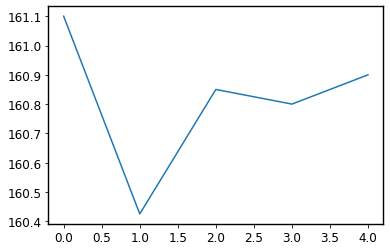

In [5]:
plt.plot(Iseq)

In [10]:
data = l.assign(ac=Iseq)[['Name', 'ac']]

In [11]:
data

,Name,ac
0,301,161.100
1,302,160.425
2,303,160.850
3,304,160.800
4,305,160.900


<IPython.core.display.Javascript object>


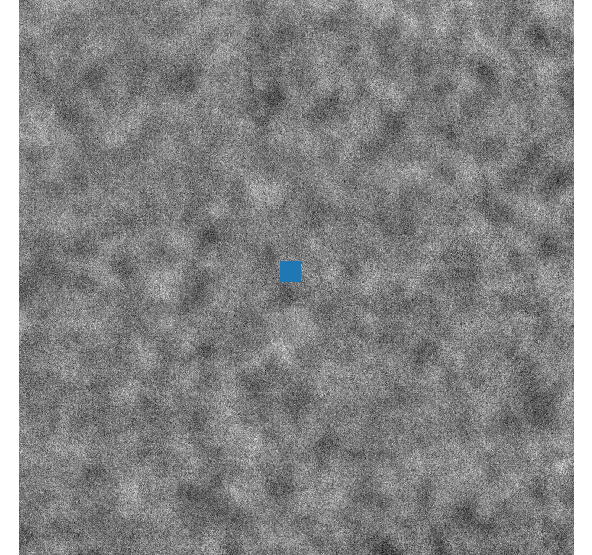

(-0.5, 2047.5, 2047.5, -0.5)

In [40]:
%matplotlib nbagg
fig = plt.figure(figsize=(3, 3), dpi=70)
ax = fig.add_axes([0,0,1,1])
ax.imshow(bp, cmap='gray')
plt.plot(X[1, 1], Y[1, 1], marker='s', markersize=20, ls='')
ax.axis('off')

In [19]:
dataDir = r'D:\Wei\transient\ac_result\020\autocorr.csv'
data = pd.read_csv(dataDir)

In [42]:
data_off = data.loc[data.Name<300]
data_on = data.loc[(data.Name>300)&(data.Name<2100)]

In [30]:
data

,Name,ac
0,0,155.950
1,1,156.075
2,2,153.425
3,3,158.125
4,4,158.600
5,5,161.750
6,6,159.850
7,7,158.300
8,8,160.175
9,9,157.525


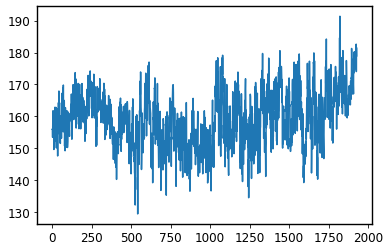

In [23]:
plt.plot(data.Name, data.ac)

In [29]:
data_on.ac.autocorr()

0.7627787291401227

In [43]:
data_off.ac = data_off.ac - data_off.ac.mean()

In [46]:
Isq = (np.array(data_off.ac)**2).sum() / len(data_off.ac)

In [47]:
Isq

27.55692535416666

In [50]:
data_off.loc[1]

Name    1.00000
ac     -5.46725
Name: 1, dtype: float64

In [133]:
length = len(data_off)
C = np.zeros((length, 1)).squeeze()
t = np.zeros((length, 1)).squeeze()
for tin in range(0, length):
    count = 0
    Ct = 0
    for ts in range(0, length-tin):
        d1 = data_off.loc[ts]
        d2 = data_off.loc[ts+tin]
        Ct += d2.ac*d1.ac
        count += 1
    Ct = Ct / count / Isq
    C[tin] = Ct
    t[tin] = tin

In [113]:
data_on = data_on.drop(columns=['index'])

In [117]:
data_on.loc[300]

Name    601.000000
ac        4.175092
Name: 300, dtype: float64

In [125]:
ac = corrT(data)

Text(0, 0.5, 'autocorrelation')

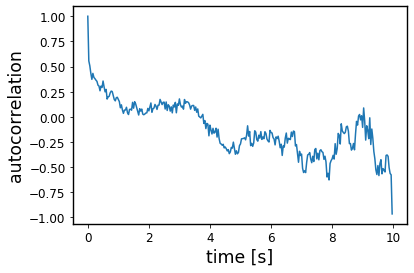

In [135]:
plt.plot(t/30, C)
plt.xlabel('time [s]')
plt.ylabel('autocorrelation')

In [124]:
def corrT(autocorr_data):
    # Calculate temporal correlation function
    # autocorr_data is a pd.DataFrame containing columns (Name, ac)
    length = len(autocorr_data)
    autocorr_data.ac = autocorr_data.ac - autocorr_data.ac.mean()
    Isq = (np.array(autocorr_data.ac)**2).sum() / length
    C = np.zeros((length, 1)).squeeze()
    t = np.zeros((length, 1)).squeeze()
    for tin in range(0, length):
        count = 0
        Ct = 0
        for ts in range(0, length-tin):
            d1 = autocorr_data.loc[ts]
            d2 = autocorr_data.loc[ts+tin]
            Ct += d2.ac*d1.ac
            count += 1
        Ct = Ct / count / Isq
        C[tin] = Ct
        t[tin] = tin
    return pd.DataFrame().assign(dt=t, C=C)

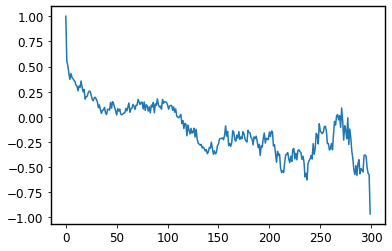

In [86]:
plt.plot(ac.dt, ac.C)